In [1]:
import pandas as pd
import temporian as tp
import ydf
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels
import numpy as np
import os
import keras
from datetime import datetime, timedelta
import statsmodels.api as sm
import urllib
import zipfile
import prophet

2024-06-11 09:04:27.749357: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-11 09:04:28.418260: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/usr/local/google/home/gbm/my_venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Part #2: Statistical Forecasting

TODO
- Intro stat forecating
- What we will do
- AirTrafic dataset

In [2]:
# TODO => DL all datasets in one place

raw_ds = pd.read_csv("datasets/air_passengers.csv", parse_dates=["Month"])
raw_ds

,Month,#Passengers
0,1949-01-01,112
1,1949-02-01,118
2,1949-03-01,132
3,1949-04-01,129
4,1949-05-01,121
...,...,...
139,1960-08-01,606
140,1960-09-01,508
141,1960-10-01,461
142,1960-11-01,390


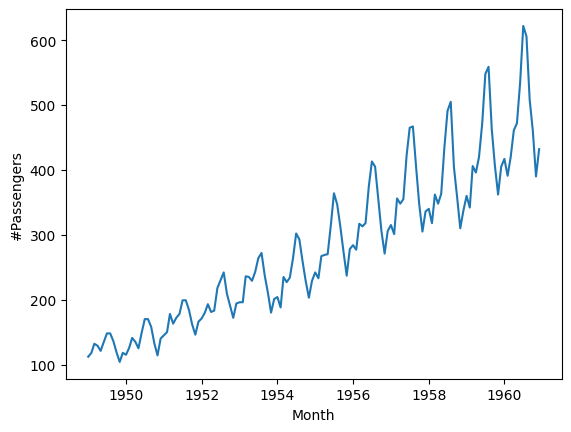

In [3]:
sns.lineplot(x="Month", y="#Passengers", data=raw_ds)
plt.show()

TODO:
- Plotting function

Intro ARIMA

Regressive linear model

In [4]:
num_test_steps = 28

model = sm.tsa.arima.ARIMA(
    endog=raw_ds["#Passengers"],
    order=(10, 0, 0),
)
model_fit = model.fit()

/usr/local/google/home/gbm/my_venv/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/google/home/gbm/my_venv/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [5]:
model_fit.params

const     280.305099
ar.L1       1.146703
ar.L2      -0.460108
ar.L3       0.178722
ar.L4      -0.304246
ar.L5       0.377636
ar.L6      -0.216369
ar.L7       0.226179
ar.L8      -0.402437
ar.L9       0.269720
ar.L10      0.180383
sigma2    629.416809
dtype: float64

Q: What does those parameter tell us? Risk in interpretting those parameters directly?

- Train / test split talk + evaluation function.

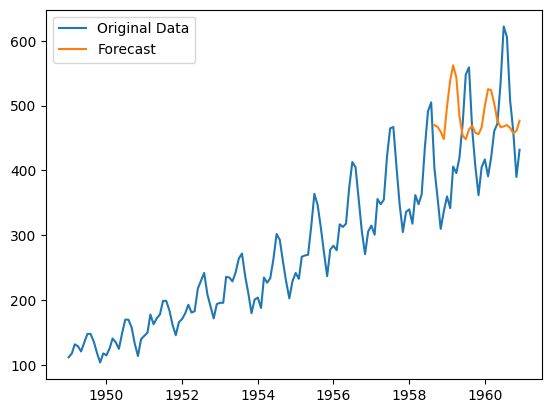

In [6]:
forecast = model_fit.forecast(steps=num_test_steps)
plt.plot(raw_ds["Month"], raw_ds["#Passengers"], label="Original Data")
plt.plot(raw_ds["Month"][-num_test_steps:], forecast, label="Forecast")
plt.legend()
plt.show()

Talk increase in model cimplexity?

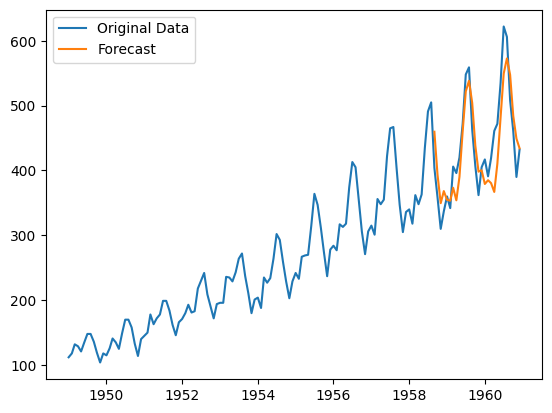

In [7]:
model = sm.tsa.arima.ARIMA(
    endog=raw_ds["#Passengers"][:-num_test_steps],
    order=(10, 2, 1),
    enforce_stationarity=False,
)
model_fit = model.fit()
forecast = model_fit.forecast(steps=num_test_steps)

plt.plot(raw_ds["Month"],raw_ds["#Passengers"], label="Observations")
plt.plot(raw_ds["Month"][-num_test_steps:],forecast, label="Forecast")
plt.legend()
plt.show()

In [8]:
residual = raw_ds["#Passengers"][-num_test_steps:] - forecast
mean_absolute_error = np.mean(np.abs(residual))
print("mean_absolute_error:", mean_absolute_error)

mean_absolute_error: 34.82438203045104


In [9]:
# Exercice: Improve params of arima model.

Discussion:
- When are there too much complexity / regulzatiation / criteria

- Looking at the data
- Intro ACF

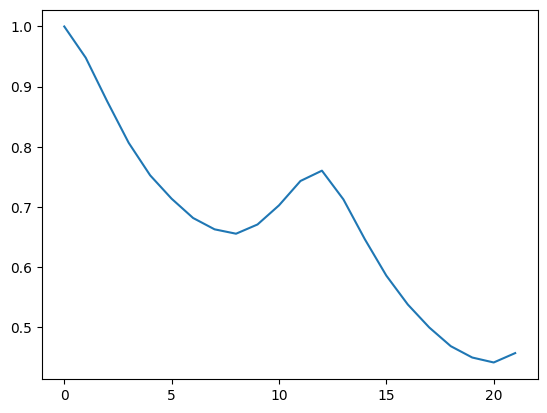

In [10]:
plt.plot(sm.tsa.acf(raw_ds["#Passengers"]))

Q:
- What can you tell?
- What does this peak at 0 and 12 tell us?
- => Last value mattern most
- => 1year ciclicity

Intro STL

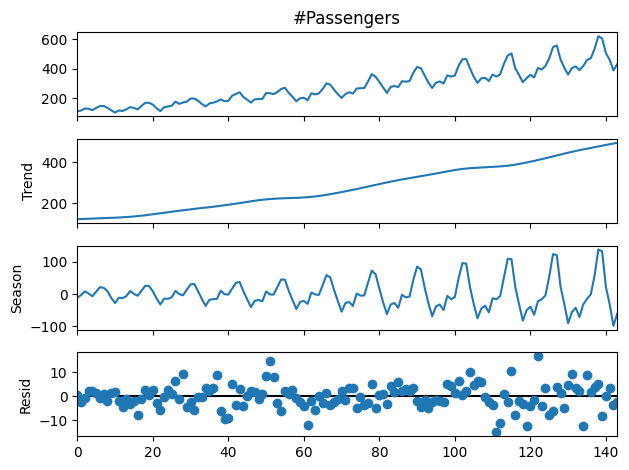

In [11]:
model = sm.tsa.STL(raw_ds["#Passengers"], period=12)
result = model.fit()
result.plot()
plt.show()

Intro modeling with STL with ETS

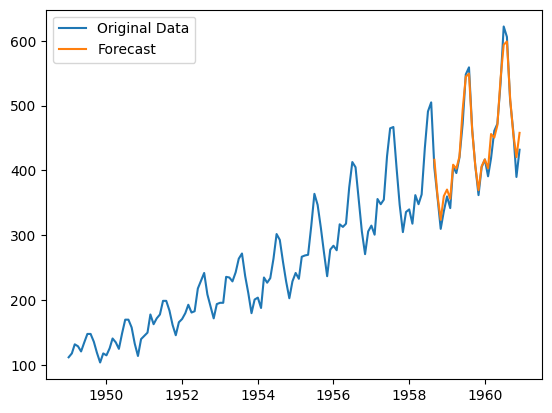

In [12]:
num_test_steps = 28

model = sm.tsa.ETSModel(
    endog=raw_ds["#Passengers"][:-num_test_steps],
    error="mul",
    trend="mul",
    seasonal="add",
    seasonal_periods=12,
)
model_fit = model.fit(disp=False)
forecast = model_fit.forecast(steps=num_test_steps)

plt.plot(raw_ds["Month"],raw_ds["#Passengers"], label="Observations")
plt.plot(raw_ds["Month"][-num_test_steps:],forecast, label="Forecast")
plt.legend()
plt.show()

In [13]:
residual = raw_ds["#Passengers"][-num_test_steps:] - forecast
mean_absolute_error = np.mean(np.abs(residual))
print("mean_absolute_error:", mean_absolute_error)

mean_absolute_error: 10.821295083651334


Manual is good to understand. Automated / integrated tools
- AutoARIMA
- SKTime
- Profet
- VertexAI forecast

/usr/local/google/home/gbm/my_venv/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/google/home/gbm/my_venv/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/google/home/gbm/my_venv/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/google/home/gbm/my_venv/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/lo

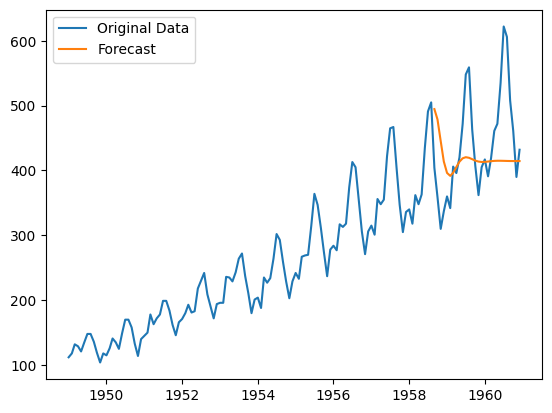

In [14]:
# DOES NOT WORK: Ask or Remove?
from sktime.forecasting.arima import AutoARIMA

model = AutoARIMA()
model.fit(raw_ds["#Passengers"][:-num_test_steps])
forecast = model.predict(range(num_test_steps))

plt.plot(raw_ds["Month"],raw_ds["#Passengers"], label="Original Data")
plt.plot(raw_ds["Month"][-num_test_steps:],forecast, label="Forecast")
plt.legend()
plt.show()

09:04:32 - cmdstanpy - INFO - Chain [1] start processing
09:04:32 - cmdstanpy - INFO - Chain [1] done processing
/usr/local/google/home/gbm/my_venv/lib/python3.11/site-packages/prophet/forecaster.py:1854: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(


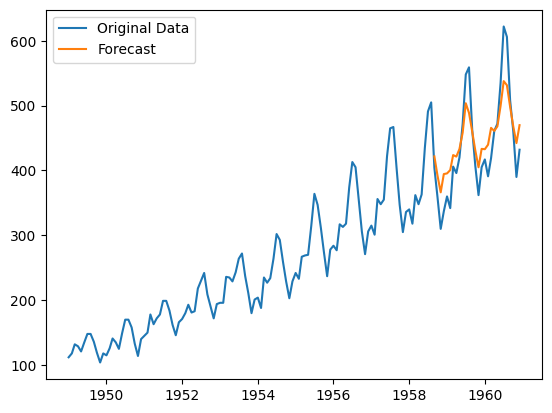

In [15]:
# DOES NOT WORK: Ask or Remove?
prophet_ds = raw_ds.rename(columns={"Month":"ds", "#Passengers":"y"})

model = prophet.Prophet()
model.fit(prophet_ds[:-num_test_steps])
forecast = model.predict(model.make_future_dataframe(periods=num_test_steps, freq="ME"))

plt.plot(raw_ds["Month"],raw_ds["#Passengers"], label="Observations")
plt.plot(raw_ds["Month"][-num_test_steps:],forecast["yhat"][-num_test_steps:], label="Forecast")
plt.legend()
plt.show()

Intro and importance of HTS
Citation ?

Intro new dataset => australia tourism

In [16]:
raw_ds = pd.read_csv("datasets/australian_tourism.csv", parse_dates=["Quarter"])
#raw_ds = raw_ds[raw_ds["State"] == "South Australia"]
#raw_ds = raw_ds[raw_ds["Purpose"] == "Visiting"]
#del raw_ds["State"]
del raw_ds["Index"]
del raw_ds["Purpose"]
del raw_ds["Region"]

def quarter_idx(x):
    """Convert a date into a number of quarter since 1998.
    Used to solved some issue between pandas and sklearn:
    https://github.com/sktime/sktime/issues/6499
    """
    dti = pd.DatetimeIndex(x)
    return dti.quarter + (dti.year - 1998) * 4
raw_ds["Quarter"] = quarter_idx(raw_ds["Quarter"])

#raw_ds = raw_ds.set_index(["State", "Quarter"]).sort_index()
raw_ds = raw_ds.groupby(["State", "Quarter"]).sum()
raw_ds

Trips
State             Quarter             
ACT               1         551.001921
                  2         416.025623
                  3         436.029011
                  4         449.798445
                  5         378.572817
...                                ...
Western Australia 72       2382.091755
                  73       2797.404767
                  74       2469.394281
                  75       2317.044544
                  76       2656.330701

[532 rows x 1 columns]

In [21]:
from sktime.transformations.hierarchical.aggregate import Aggregator
from sktime.transformations.hierarchical.reconcile import Reconciler
from sktime.forecasting.arima import ARIMA
from sktime.forecasting.exp_smoothing import ExponentialSmoothing
# import warnings
# warnings.filterwarnings("ignore")

# model = Aggregator() * ARIMA(
#     order=(5, 1, 1),
#     seasonal_order=(5,1,1,4),
#     suppress_warnings=True,
# ) * Reconciler()

model = Aggregator() * ExponentialSmoothing(trend="mul", seasonal="mul",sp=4) * Reconciler()
model.fit(raw_ds)
forecast = model.predict(range(4 * 4))
forecast

/usr/local/google/home/gbm/my_venv/lib/python3.11/site-packages/statsmodels/tsa/holtwinters/model.py:84: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
/usr/local/google/home/gbm/my_venv/lib/python3.11/site-packages/statsmodels/tsa/holtwinters/model.py:84: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
/usr/local/google/home/gbm/my_venv/lib/python3.11/site-packages/statsmodels/tsa/holtwinters/model.py:84: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
/usr/local/google/home/gbm/my_venv/lib/python3.11/site-packages/statsmodels/tsa/holtwinters/model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/usr/local/google/home/gbm/my_venv/lib/python3.11/site-packages/statsmodels/tsa/holtwinters/model.py:84: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
/usr/local/google/home/gbm/my_venv/lib/python3.11/site-packages/statsmodels/tsa/holtwinters/model.py:84: RuntimeW

Trips
State   Quarter              
ACT     76         573.973102
        77         605.959189
        78         616.267520
        79         638.615550
        80         627.324314
...                       ...
__total 87       28815.134732
        88       30425.085016
        89       33429.118820
        90       30862.652104
        91       30259.751012

[128 rows x 1 columns]

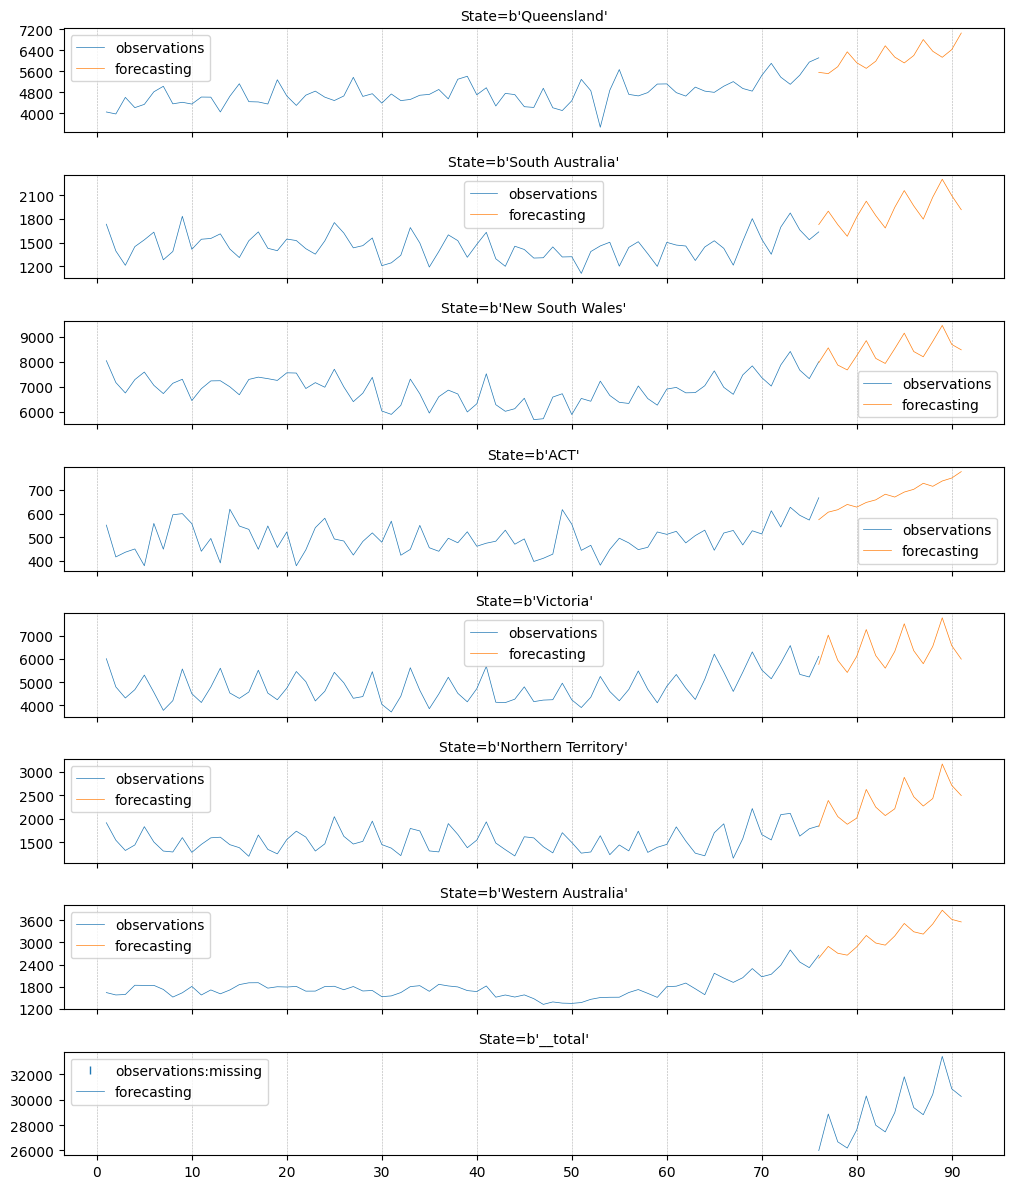

In [22]:
tp.plot([
    tp.from_pandas(raw_ds.reset_index(),
               timestamps="Quarter",
               indexes=["State"]).rename("observations"),
    tp.from_pandas(forecast.reset_index(),
               timestamps="Quarter",
               indexes=["State"]).rename("forecasting"),
], merge=True)

Q: Add "region" in the hts

List of all stat libraries

What we learned so far